
## **Optional exercise number 1: Variational Autoenconder**




In [0]:
import numpy as np
#We'll make it reproducible by using this seed
np.random.seed(1)
import torch
torch.manual_seed(1)
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
from torchvision import datasets, transforms
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import torch.optim as optim

### Load the MNIST datasets into DataLoaders

In [0]:
hparams = {
    'batch_size':64,
    'learning_rate':1e-3,
    'test_batch_size':64
}

mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))


# The argument "drop_last=True" is given in order to ensure that there won't be a last batch that is not full
train_loader = torch.utils.data.DataLoader(mnist_trainset,
                                            batch_size=hparams['batch_size'], 
                                            shuffle=True,drop_last=True) #Probar si peta sin el drop_last pero no es prioritario

test_loader = torch.utils.data.DataLoader(mnist_testset,
                                          batch_size=hparams['test_batch_size'], 
                                          shuffle=False,drop_last=True)



  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 10547448.76it/s]                           


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 136732.86it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2469374.04it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 53823.08it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


# Definition of the network
The VAE will be a combination of an Encoder + Decoder with the use of the parametrization trick in between them

In [0]:
class Encoder(nn.Module):
   ''' 
   This the encoder part of the VAE
   '''
   def __init__(self, bottleneck):
     super().__init__()

     self.conv1 = nn.Conv2d(1,32,3,padding=1)
     self.pool  = nn.MaxPool2d(2,2)
     self.conv2 = nn.Conv2d(32,16,3,padding=1)
     self.conv3 = nn.Conv2d(16,8,3,padding=1)
     self.fc      = nn.Linear(8*7*7, bottleneck)
     self.media = nn.Linear(bottleneck,bottleneck)
     self.logvar  = nn.Linear(bottleneck,bottleneck)

   def forward(self,x):
      ## encode ##


      x = F.relu(self.conv1(x))
      x = self.pool(x)
      x = F.relu(self.conv2(x))
      x = self.pool(x)
      x = F.relu(self.conv3(x))
      x = x.view(-1, 8*7*7)
      x = F.relu(self.fc(x))
      z_media = self.media(x)
      logvar   = self.logvar(x)

      return z_media, logvar

class Decoder(nn.Module):
   ''' 
   This the decoder part of the VAE
   '''

   def __init__(self, bottleneck):
     super().__init__()

     ## decoder layers ##
     ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
     self.linear = nn.Linear(bottleneck, 8*7*7)
     self.t_conv1 = nn.ConvTranspose2d(8, 16, 2, stride=2)
     self.t_conv2 = nn.ConvTranspose2d(16, 32, 2, stride=2)
     self.t_conv3 = nn.ConvTranspose2d(32,1,1)

   def forward(self,x):
     ## decode ##
     x = F.relu(self.linear(x))
     x = x.view(-1, 8, 7, 7)
     x = F.relu(self.t_conv1(x))
     # output layer (with sigmoid for scaling from 0 to 1)
     x = F.relu(self.t_conv2(x))
     x = torch.sigmoid(self.t_conv3(x))
            
     return x

class VAE(nn.Module):
  '''
  This takes both encoder and decoder into the same network
  '''
  def __init__(self, enc, dec):
    super().__init__()

    self.encoder = enc
    self.decoder = dec

  def forward(self,x):
    #encode
    z_media,logvar = self.encoder(x)
  
    # Reparametrization trick
    std = torch.exp(0.5*logvar)
    # Standard Gaussian with correct size
    eps = torch.randn_like(std)
    # This allows for the gradients to flow
    x_sample = z_media + eps*std
 
    #Decode
    predicted = self.decoder(x_sample)

    return predicted,z_media,logvar
      

# Now we have to train the network for a number of epochs
In order to make this in a propper manner we define a train() function

In [0]:
def lossFunction(data,z_mu,logvar,prediction):
    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(prediction, data, reduction='sum')
    # KL divergence loss
    kld = -0.5 * torch.sum(1+logvar - z_mu.pow(2) - logvar.exp()) * 600 #This 600 is the disentangle parameter.

    # total loss
    loss = recon_loss + kld
    return loss, recon_loss, kld


def train(model, num_epochs):
  # Prepare the GPU and the model to start training
  model.train()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr = hparams['learning_rate']) # learning rate chosen at random
  
  for epoch in range(num_epochs):
    # For tracking the loss of the model
    closs = 0
    crl, ckdl = 0, 0
    for batch_idx, (data,_) in enumerate(train_loader):
      # Put data and label into GPU
      data = data.to(device)
      
      # What does the model say 
      prediction, z_mu,logvar = model(data)
      loss, rl, kdl = lossFunction(data,z_mu,logvar,prediction)
      closs += loss.item() 
      crl += rl
      ckdl += kdl
      # Name a more iconic trio
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    print('Epoch: {} \tRecon Loss: {:.6f}\tKDL Loss: {:.6f}'.format(epoch+1,crl/len(mnist_trainset), ckdl/len(mnist_trainset)))  



In [0]:
BotNeck = 20

encoder = Encoder(BotNeck)
decoder = Decoder(BotNeck)
model = VAE(encoder,decoder)


train(model,30)

Epoch: 1 	Recon Loss: -8084.705078	KDL Loss: 50.886410
Epoch: 2 	Recon Loss: -9166.176758	KDL Loss: 65.162643
Epoch: 3 	Recon Loss: -7863.810059	KDL Loss: 66.644249
Epoch: 4 	Recon Loss: -7294.259277	KDL Loss: 68.521111
Epoch: 5 	Recon Loss: -6910.531250	KDL Loss: 77.971512
Epoch: 6 	Recon Loss: -6316.003906	KDL Loss: 104.015381
Epoch: 7 	Recon Loss: -6033.281738	KDL Loss: 164.924164
Epoch: 8 	Recon Loss: -6002.853027	KDL Loss: 233.169952
Epoch: 9 	Recon Loss: -5967.974121	KDL Loss: 267.618011
Epoch: 10 	Recon Loss: -5922.564941	KDL Loss: 289.501892
Epoch: 11 	Recon Loss: -5906.636230	KDL Loss: 296.553345
Epoch: 12 	Recon Loss: -5895.642090	KDL Loss: 310.707397
Epoch: 13 	Recon Loss: -5886.431641	KDL Loss: 316.706268
Epoch: 14 	Recon Loss: -5889.387695	KDL Loss: 330.988251
Epoch: 15 	Recon Loss: -5906.155273	KDL Loss: 336.085297
Epoch: 16 	Recon Loss: -5909.641113	KDL Loss: 343.030975
Epoch: 17 	Recon Loss: -5918.229004	KDL Loss: 348.876556
Epoch: 18 	Recon Loss: -5914.995117	KDL Loss:

torch.Size([1, 20])
torch.Size([28, 28])


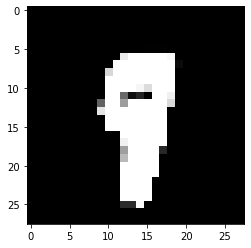

In [0]:
# sample and generate a image
z = torch.randn(1, BotNeck)
model.to("cpu")
# run only the decoder
reconstructed_img = model.decoder(z)

# Go home and run this.
print(z.shape)
print(reconstructed_img.detach().squeeze().shape)

plt.imshow(reconstructed_img.detach().squeeze().numpy(), cmap='gray')

As we can see, the model can't form digits very well. It is fairly simple to see that they look similar to the MNIST dataset but the result is still pretty clumsy. We use 600 as the disentangle hyperparameter.